In [1]:
import sys
import itertools
import math
import numpy as np
import json
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import dstep, dlti

import experimental.utils as utils
from experimental.agent import PIDTuningAgent
from experimental.environment import PIDTuningEnvironment
from experimental.runner import Runner
from experimental.runner_opt import Runner_opt

warnings.filterwarnings("ignore")

In [2]:
#Choose testcase and experiment
testcase = 5
experiment = 14

In [3]:
#Open json file

f = open(f'config/testcase_synt_{testcase}.json')
param_dict = json.load(f)

horizon = param_dict['horizon']
n_trials = param_dict['n_trials']
sigma = param_dict['noise_sigma']

n = param_dict['n']
p = param_dict['p']
m = param_dict['m']

A = np.array(param_dict['A'])
b = np.array(param_dict['B'])
c = np.array(param_dict['C'])

#Step signal
y_0 = 1

In [4]:
#Define dictionary for the errors of the algorithms
optimal = "optimal"
pidtuning = "pidtuning"
ziegler_nichols = "ziegler_nichols"
alg_list = [optimal, pidtuning, ziegler_nichols]
errors = {alg: np.zeros((n_trials, horizon)) for alg in alg_list}

In [ ]:
#Define noises
np.random.seed(1)
noise = np.random.normal(0, sigma, (n_trials, horizon, n))
out_noise = np.random.normal(0, sigma, (n_trials, horizon, m))

In [ ]:
#Define range of possible PID parameters
log_space = np.logspace(0, 1, num=25, base=10)

K_P_range_start = 0.0
K_P_range_end = 1.7
K_P_range = (log_space - log_space.min()) / (log_space.max() - log_space.min()) *\
      (K_P_range_end - K_P_range_start) + K_P_range_start

K_I_range_start = 0.0
K_I_range_end = 2.3
K_I_range = (log_space - log_space.min()) / (log_space.max() - log_space.min()) *\
      (K_I_range_end - K_I_range_start) + K_I_range_start

K_D_range_start = 0.0
K_D_range_end = 0.8
K_D_range = (log_space - log_space.min()) / (log_space.max() - log_space.min()) *\
      (K_D_range_end - K_D_range_start) + K_D_range_start

In [ ]:
#Build list of ammissible PID parameters
pid_actions = []
for K in list(itertools.product(K_P_range, K_I_range, K_D_range)):
    bar_A = utils.compute_bar_a(A, b, c, K)
    if (np.max(np.absolute(np.linalg.eigvals(bar_A))) < 0.4): 
        pid_actions.append(np.array(K).reshape(3,1))

pid_actions = np.array(pid_actions)
n_arms = pid_actions.shape[0]
print(n_arms)

In [ ]:
print(n_arms)
print(np.max(pid_actions[:,0,:]))
print(np.max(pid_actions[:,1,:]))
print(np.max(pid_actions[:,2,:]))

### Optimal algorithm

In [ ]:
#Run optimal algorithm

env = PIDTuningEnvironment(A, b, c, n, p, m, y_0, horizon, noise, out_noise, n_trials)
print('Running Optimal algorithm')

all_errors = np.zeros((n_arms, n_trials, horizon))
np.save("optimal_errors1.npy", all_errors)
all_SSE = np.zeros((n_arms, n_trials))
K_opt_idx = np.zeros(n_trials)
K_opt = np.zeros((n_trials, 3, 1))
for i, K in enumerate(pid_actions):
    print("Running simulation ", i)
    runner_opt = Runner_opt(env, n_trials, horizon, 3, n_arms, pid_actions)
    all_errors[i] = runner_opt.perform_simulations(K, i)
    for trial_i in range(n_trials):
        all_SSE[i, trial_i] = np.sum(all_errors[i, trial_i]**2)
for trial_i in range(n_trials):
    K_opt_idx[trial_i] = np.argmin(all_SSE[:, trial_i])
    K_opt[trial_i] = pid_actions[int(K_opt_idx[trial_i])]
    errors[optimal][trial_i,:] = all_errors[int(K_opt_idx[trial_i]), trial_i, :]
np.save("optimal_errors1.npy", errors[optimal])
np.save("K_opt_idx_1", K_opt_idx)
np.save("K_opt_1", K_opt)
np.save("all_errors_1.npy", all_errors)

In [ ]:
#Plot K_P and SSE, fixed K_I and K_D
idx = []
for i, K in enumerate(pid_actions):
    if (K[1] == K_opt[0][1] and K[2] == K_opt[0][2]):
        idx.append(i)
y_plot = []
x_plot = []
for i in idx:
    y_plot.append(all_SSE[i][0])
    x_plot.append(pid_actions[i][0][0])

print(K_opt[0][0][0])

plt.figure()
plt.plot(np.array(x_plot), np.array(y_plot))
plt.xlabel('K_P')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

In [ ]:
#Plot K_D and SSE, fixed K_P and K_I
idx = []
for i, K in enumerate(pid_actions):
    if (K[0] == K_opt[0][0] and K[1] == K_opt[0][1]):
        idx.append(i)
y_plot = []
x_plot = []
for i in idx:
    y_plot.append(all_SSE[i][0])
    x_plot.append(pid_actions[i][2][0])

print(K_opt[0][2][0])

plt.figure()
plt.plot(np.array(x_plot), np.array(y_plot))
plt.xlabel('K_D')
plt.ylabel('SSE')
plt.grid(True)
plt.show()


In [ ]:
#Plot K_I parameters and SSE, fixed K_P and K_D
idx = []
for i, K in enumerate(pid_actions):
    if (K[0][0] == K_opt[0][0][0] and K[2][0] == K_opt[0][2][0]):
        idx.append(i)
y_plot = []
x_plot = []
for i in idx:
    y_plot.append(all_SSE[i][0])
    x_plot.append(pid_actions[i][1][0])

print(K_opt[0][1][0])

plt.figure()
plt.plot(np.array(x_plot), np.array(y_plot))
plt.xlabel('K_I')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

### Ziegler-Nichols open loop

In [ ]:
#Load .mat file containing step response
import scipy.io

mat = scipy.io.loadmat('step_response.mat')
data = mat['data']

y_zn = data[:, 1]
print(np.shape(y_zn))

In [ ]:
#Compute step response

d = np.array([0])
system = dlti(A, b, c, d, dt=True)
t = np.arange(horizon)
_, y_zn = dstep(system, t=t)
y_zn = np.squeeze(y_zn)

plt.figure(figsize = (10,6))
plt.plot(t, y_zn)
plt.title('Step Response')
plt.xlabel('Time')
plt.ylabel('Output')
plt.grid(True)
plt.show()


In [ ]:
#Running step response simulation

from experimental.environment_step import StepEnvironment
from experimental.runner_step import RunnerStep

experiment_zn = 1
all_outputs = np.zeros((n_trials, horizon))
np.savez_compressed(f"step_{experiment_zn}.npz", all_outputs = all_outputs)
env = StepEnvironment(A, b, c, n, p, m, y_0, horizon, noise, out_noise, n_trials)
print('Running step response simulation')
runner = RunnerStep(env,  n_trials, horizon)
all_outputs = runner.perform_simulations(y_0, experiment_zn)
np.savez_compressed(f"step_{experiment_zn}.npz", all_outputs = all_outputs)


In [ ]:
#Plot mean step response
output_mean = np.mean(all_outputs, axis=0)
output_std = np.std(all_outputs, axis=0) / np.sqrt(n_trials)

plt.figure(figsize=(10, 6))
plt.plot(output_mean, label='Step response mean')
plt.fill_between(range(len(output_mean)), 
                 output_mean - output_std, 
                 output_mean + output_std, 
                 color='b', alpha=0.2, label='Step response std')
plt.title('Step Response')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Compute regret for Ziegler-Nichols algorithm

inst_regret_zn = np.zeros(horizon)
cum_regret_zn = np.zeros(horizon)

errors[ziegler_nichols] = y_0 - all_outputs
inst_regret_zn = np.zeros((n_trials, horizon))
cum_regret_zn = np.zeros((n_trials, horizon))
inst_regret_zn =  errors[ziegler_nichols]**2 - errors[optimal][:,0:horizon]**2
for trial_i in range(n_trials):
    cum_regret_zn[trial_i] = np.cumsum(inst_regret_zn[trial_i])
cum_regret_mean_zn = np.mean(cum_regret_zn, axis=0)
cum_regret_std_zn = np.std(cum_regret_zn, axis=0) / np.sqrt(n_trials)

In [ ]:
#Plot cumulative mean regret with std deviation
plt.figure(figsize=(10, 6))

plt.plot(cum_regret_mean_zn, label='Ziegler-Nichols')
plt.fill_between(range(len(cum_regret_mean_zn)), 
                 cum_regret_mean_zn - cum_regret_std_zn, 
                 cum_regret_mean_zn + cum_regret_std_zn, 
                 color='b', alpha=0.2, label='Standard Error Ziegler-Nichols')

plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.title("Cumulative mean regret with standard deviation")
plt.show()

### PID Tuning algorithm

In [ ]:
#Upper bound for relevant quantities
action_max = pid_actions[np.argmax([np.linalg.norm(np.array(K), 2) for K in pid_actions])]
K_val = np.linalg.norm(action_max, 2)
b_val = np.linalg.norm(b, 2)
c_val = np.linalg.norm(c, 2)
spectral_rad_ub = max(np.linalg.eigvals(A))
phi_a_ub = utils.spectr(A)
y_0 = 1


#Upper bound for noise
noise_norm = []
for trial_i in range(n_trials):
    for t in range(horizon):
        noise_norm.append(np.linalg.norm(noise[trial_i, t, :]))
        noise_norm.append(np.linalg.norm(out_noise[trial_i, t, :]))
noise_ub = max(np.array(noise_norm))


#Upper bound for spectral radius of matrix bar_A
spectral_rad_list = []
for K in pid_actions:
    bar_A = utils.compute_bar_a(A, b, c, K)
    spectral_rad_list.append(np.max(np.absolute(np.linalg.eigvals(bar_A))))

spectral_rad_bar_ub = np.max(np.array(spectral_rad_list))
bar_A = utils.compute_bar_a(A, b, c, pid_actions[np.argmax(np.array(spectral_rad_list))])
phi_bar_a_ub = utils.spectr(bar_A)

print(spectral_rad_bar_ub)

In [ ]:
#Create file for PIDTuning algorithm checkpoints
#It saves the error at each time, for each simulation
#It works even with interruptions
temp = np.zeros((n_trials, horizon))
np.save("pid_tuning_errors_1.npy", temp)
temp = np.zeros((n_trials, horizon, 3, 1))
np.save("pulled_arms_1.npy", temp)

In [ ]:
#Running PIDTuning
agent = PIDTuningAgent(n_arms, pid_actions, horizon,
                            np.log(horizon), b_val, c_val, K_val, phi_a_ub, phi_bar_a_ub, y_0,
                            spectral_rad_ub, spectral_rad_bar_ub, noise_ub, sigma)
env = PIDTuningEnvironment(A, b, c, n, p, m, y_0, horizon, noise, out_noise, n_trials)
print('Running PID Tuning')
runner = Runner(env, agent, n_trials, horizon, 3, n_arms, pid_actions)
errors[pidtuning] = runner.perform_simulations()
np.save("pid_tuning_errors1.npy", errors[pidtuning])

### Regret

In [5]:
#Load data

errors[pidtuning] = np.load(f'.\experiments\experiment_{experiment}\pid_tuning_errors{experiment}.npy', allow_pickle=True)
if (experiment!=1):
    loaded = np.load(f".\experiments\experiment_{experiment}\experiment_{experiment}.npz", allow_pickle=True)
    errors[optimal] = loaded['optimal_errors']
    K_opt = loaded['K_opt']
    K_opt_idx = loaded['K_opt_idx']
    pid_actions = loaded['pid_actions']
else:
    errors[optimal] = np.load(".\experiments\experiment_1\optimal_errors1.npy", allow_pickle=True)
    K_opt = np.load(".\experiments\experiment_1\K_opt_1.npy", allow_pickle=True)
    K_opt_idx = np.load(".\experiments\experiment_1\K_opt_idx_1.npy", allow_pickle=True)

#Print shapes
print(np.shape(errors[pidtuning]))
print(np.shape(errors[optimal]))

#Print best PID action for each simulation
print(K_opt_idx)

#Print max P, I, D parameters contained in pid_actions
print("Max P parameter:", np.max(pid_actions[:,0,:]))
print("Max I parameter:", np.max(pid_actions[:,1,:]))
print("Max D parameter:", np.max(pid_actions[:,2,:]))

(10, 10000)
(10, 100000)
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Max P parameter: 1.7
Max I parameter: 1.326245981610999
Max D parameter: 0.08509704724334757


In [ ]:
#Print SSE for each simulation using optimal PID action

loaded = np.load(f".\experiments\experiment_{experiment}\experiment_{experiment}.npz", allow_pickle=True)
errors[optimal] = loaded['optimal_errors']

sse = np.zeros(10)
for sim in range(n_trials):
    sse[sim] = np.sum(errors[optimal][sim]**2)
print(sse)


In [6]:
#Compute regret for PIDTuning

inst_regret = np.zeros((n_trials, horizon))
cum_regret = np.zeros((n_trials, horizon))

inst_regret =  errors[pidtuning] **2 - errors[optimal][:,0:horizon]**2
for trial_i in range(n_trials):
    cum_regret[trial_i] = np.cumsum(inst_regret[trial_i])
cum_regret_mean = np.mean(cum_regret, axis=0)
cum_regret_std = np.std(cum_regret, axis=0) / np.sqrt(n_trials)

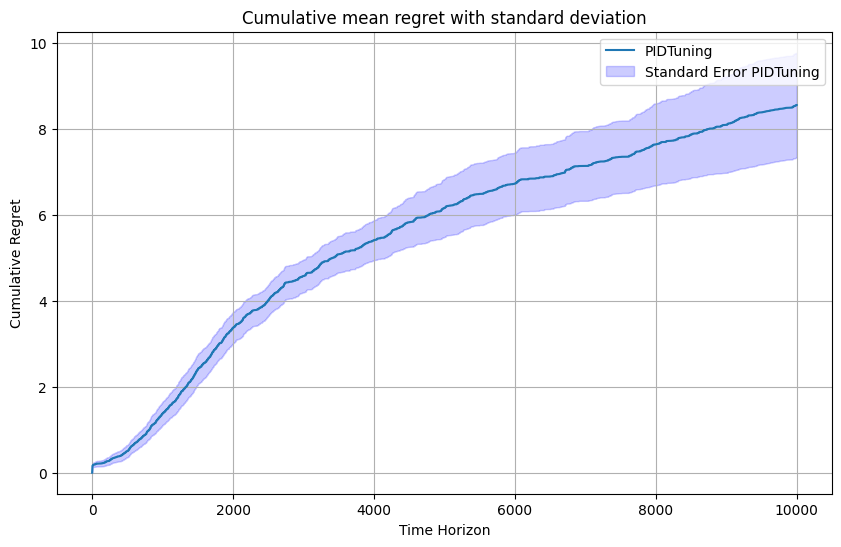

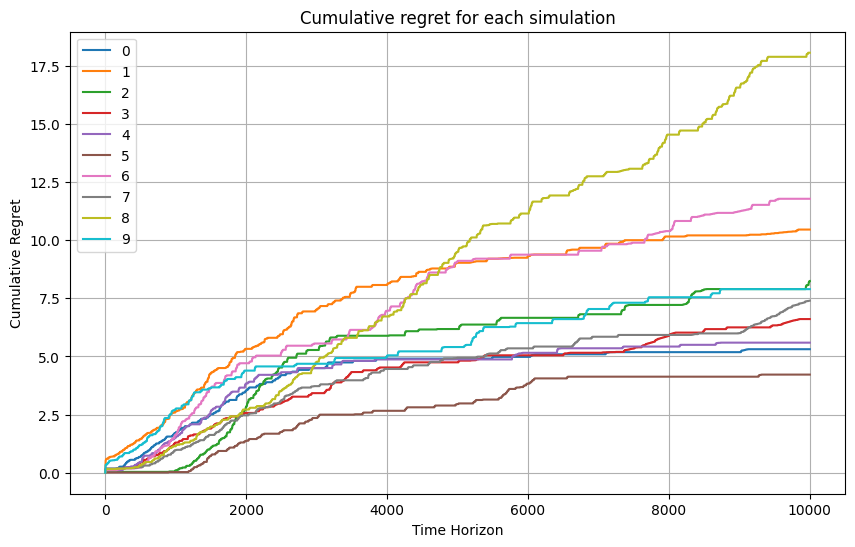

In [7]:
#Plot cumulative mean regret with std deviation
plt.figure(figsize=(10, 6))

plt.plot(cum_regret_mean, label='PIDTuning')
plt.fill_between(range(len(cum_regret_mean)), 
                 cum_regret_mean - cum_regret_std, 
                 cum_regret_mean + cum_regret_std, 
                 color='b', alpha=0.2, label='Standard Error PIDTuning')

plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.title("Cumulative mean regret with standard deviation")
plt.show()

#Plot all simulations
plt.figure(figsize=(10, 6))
for i in range(n_trials):
    label = str(i)
    plt.plot(cum_regret[i], label=label)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.title("Cumulative regret for each simulation")
plt.show()


In [ ]:
#Plot cumulative mean regret with std deviation for PIDTuning and Ziegler-Nichols
plt.figure(figsize=(10, 6))

plt.plot(cum_regret_mean, label='PIDTuning')
plt.fill_between(range(len(cum_regret_mean)), 
                 cum_regret_mean - cum_regret_std, 
                 cum_regret_mean + cum_regret_std, 
                 color='b', alpha=0.2, label='Standard Error PIDTuning')

plt.plot(cum_regret_mean_zn, label='Ziegler-Nichols')
plt.fill_between(range(len(cum_regret_mean_zn)), 
                 cum_regret_mean_zn - cum_regret_std_zn, 
                 cum_regret_mean_zn + cum_regret_std_zn, 
                 color='b', alpha=0.2, label='Standard Error Ziegler-Nichols')

plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.title("Cumulative mean regret with standard deviation")
plt.show()

In [ ]:
#Plot all simulations except simulation 1
plt.figure(figsize=(10, 6))
for i in range(n_trials):
    if(i!=1):
        plt.plot(cum_regret[i], label=str(i))
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.show()

#Plot only simulation 1
plt.figure(figsize=(10, 6))
plt.plot(cum_regret[1], label="Simulation 1")
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Plot pulled PID actions
pulled_arms = np.load(f".\experiments\experiment_{experiment}\pulled_arms_{experiment}.npy", allow_pickle=True)
pulled_arms = pulled_arms.reshape(n_trials, horizon, 3)
pid_actions_reshaped = pid_actions.reshape(len(pid_actions), 3)

list = np.zeros((n_trials, horizon))
for sim_i in range(n_trials):
    for t in range(horizon):
        match = np.all(pid_actions_reshaped == pulled_arms[sim_i, t], axis=1)
        index = np.where(match)[0]
        list[sim_i, t] = index

sim = 8
plt.figure(figsize=(15, 6))
plt.scatter(np.arange(horizon), list[sim], s=10)
plt.grid(True)
plt.yticks(range(0, len(pid_actions)))
plt.xticks(range(0, horizon, int(horizon/10)))
plt.xlabel('Time Horizon')
plt.ylabel('PID action index')
plt.title(f"Pulled PID actions in simulation {sim}")
plt.show()

In [ ]:
n_arms = np.shape(pid_actions)[0]
inst_regret = np.zeros((n_trials, horizon*10))
cum_regret = np.zeros((n_trials, horizon*10))
all_errors = loaded['all_errors']
all_SSE = np.zeros((n_arms, n_trials))
for i in range(n_arms):
    for sim_i in range(n_trials):
        all_SSE[i, sim_i] = np.sum(all_errors[i, sim_i, 10:]**2)

#inst_regret =  all_errors[0]**2 - errors[optimal] **2
inst_regret[:,10:] =  all_errors[0][:,10:] **2 - all_errors[2][:,10:] **2
for trial_i in range(n_trials):
    cum_regret[trial_i,10:] = np.cumsum(inst_regret[trial_i,10:])

#Plotting
plt.figure(figsize=(10, 6))

plt.plot(cum_regret[0,10:], label='PIDTuning')

print(all_SSE[0])
print(all_SSE[2])
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.xlim(50,1000)
plt.grid(True)
plt.show()


In [ ]:
#Plotting
plt.figure(figsize=(10, 6))
for i in range(len(pid_actions)):
    inst_regret =  all_errors[i]**2
    inst_regret_mean = np.mean(inst_regret, axis=0)
    plt.plot(inst_regret_mean[20:], label=i, alpha=0.1)

plt.legend()